# Nonlinear adaptive control

In this example, we will use the PES learning rule
to learn the effects of gravity, applied to a 2-joint arm.

This example requires the `abr_control` library.
To install it,

```
git clone https://github.com/abr/abr_control.git
pip install -e abr_control
```

Note that while this example uses a simualted 2-joint arm,
the underlying network structure is identical
to the network previously used to
control a physical robot arm.

In [1]:
%matplotlib inline
from abr_control.arms import twojoint as arm
from abr_control.controllers import OSC
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_loihi

nengo_loihi.set_defaults()

## Creating the arm simulation and reaching framework

The first thing to do is create the arm simulation
to simulate the dynamics of a two link arm,
and an operational space controller to calculate
what torques to apply to the joints
to move the hand in a straight line to the targets.

In [2]:
# set the initial position of the arm
robot_config = arm.Config(use_cython=True)
arm_sim = arm.ArmSim(robot_config=robot_config, dt=1e-3, q_init=[0.95, 2.0])

# create an operational space controller
ctrlr = OSC(robot_config, kp=10, kv=7, vmax=[10, 10])


Robot has fewer DOF (2) than the specified number of space dimensions to control (3), Poor performance may result.



Next we create a set of targets for the arm to reach to.
In this task the hand will start at a center location,
then reach out and back to 4 targets around a circle.

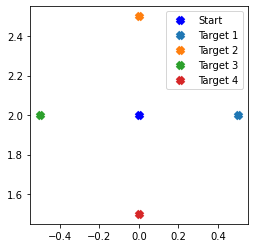

In [3]:
# create a set of targets to reach to
n_reaches = 4
seconds_per_target = 1.5

distance = 0.5
center = [0, 2.0]
end_points = [
    [distance * np.cos(theta) + center[0], distance * np.sin(theta) + center[1]]
    for theta in np.linspace(0, 2 * np.pi, n_reaches + 1)
][:-1]
targets = np.vstack([[center, ep] for ep in end_points])

plt.plot(center[0], center[1], "bx", mew=5, label="Start")
for i, end_point in enumerate(end_points):
    plt.plot(end_point[0], end_point[1], "x", mew=5, label=f"Target {i + 1}")
plt.gca().set_aspect("equal")
plt.legend()

In [4]:
def build_baseline_model():
    with nengo.Network(label="Nonlinear adaptive control") as model:

        # Create node that specifies target
        def gen_target(t):
            # Advance to the next target in the list every 2 seconds
            return targets[int(t / seconds_per_target) % len(targets)]

        target_node = nengo.Node(output=gen_target, size_out=2)

        # Create node that calculates the OSC signal
        model.osc_node = nengo.Node(
            output=lambda t, x: ctrlr.generate(
                q=x[:2], dq=x[2:4], target=np.hstack([x[4:6], np.zeros(4)])
            ),
            size_in=6,
            size_out=2,
        )

        # Create node that runs the arm simulation and gets feedback
        def arm_func(t, x):
            u = x[:2]  # the OSC signal
            u += x[2:4] * 10  # add in the adaptive control signal
            arm_sim.send_forces(u)  # step the arm simulation forward
            # return arm joint angles, joint velocities, and hand (x,y)
            return np.hstack([arm_sim.q, arm_sim.dq, arm_sim.x])

        model.arm_node = nengo.Node(output=arm_func, size_in=4)

        # hook up the OSC controller and arm simulation
        nengo.Connection(model.osc_node, model.arm_node[:2])
        nengo.Connection(model.arm_node[:4], model.osc_node[:4])
        # send in current target to the controller
        nengo.Connection(target_node, model.osc_node[4:6])

        model.probe_target = nengo.Probe(target_node)  # track targets
        model.probe_hand = nengo.Probe(model.arm_node[4:6])  # track hand (x,y)
        model.probe_q = nengo.Probe(model.arm_node[:2])  # track joint angles

    return model


baseline_model = build_baseline_model()

## Running the network in Nengo

We can now run the basic framework,
where the operational space controller
will drive the hand to the 4 targets around the circle.

In [5]:
# each reach is `seconds_per_target` seconds out + the same back in
runtime = seconds_per_target * (2 * n_reaches + 1)

arm_sim.reset()
with nengo.Simulator(baseline_model, progress_bar=False) as sim:
    sim.run(runtime)
baseline_t = sim.trange()
baseline_data = sim.data

The error is calculated as the difference
between the hand (x,y) position and the target.
Whenever the target changes, the error will jump up,
and then quickly decrease as the hand approaches the target.

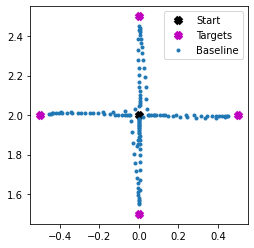

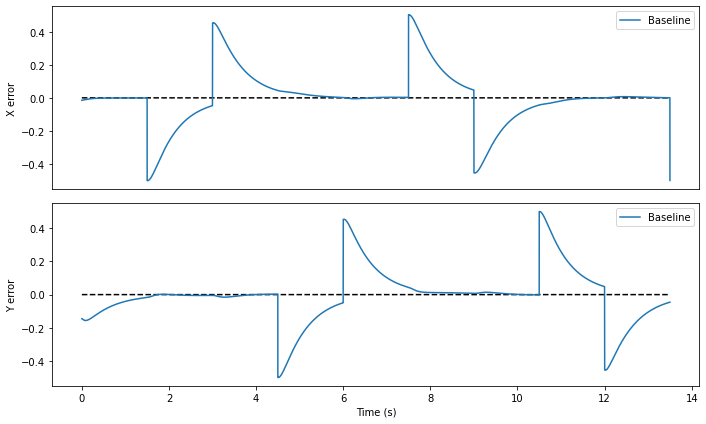

In [6]:
def calculate_error(model, data):
    return data[model.probe_hand] - data[model.probe_target]


baseline_error = calculate_error(baseline_model, baseline_data)


def plot_data(t_set, data_set, label_set):
    plt.figure(figsize=(10, 6))
    plt.title("Distance to target")

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_set[0], np.zeros_like(t_set[0]), "k--")
    plt.xticks([])
    plt.ylabel("X error")

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(t_set[0], np.zeros_like(t_set[0]), "k--")
    plt.ylabel("Y error")
    plt.xlabel("Time (s)")

    plt.tight_layout()

    for t, data, label in zip(t_set, data_set, label_set):
        ax1.plot(t, data[:, 0], label=label)
        ax2.plot(t, data[:, 1], label=label)

    ax1.legend(loc=1)
    ax2.legend(loc=1)


def plot_xy(t_set, data_set, label_set):
    tspace = 0.1
    ttol = 1e-5

    plt.figure()
    ax = plt.subplot(111)
    ax.plot(center[0], center[1], "kx", mew=5, label="Start")
    ax.plot(
        [p[0] for p in end_points],
        [p[1] for p in end_points],
        "mx",
        mew=5,
        label="Targets",
    )
    for t, data, label in zip(t_set, data_set, label_set):
        tmask = (t + ttol) % tspace < 2 * ttol
        ax.plot(data[tmask, 0], data[tmask, 1], ".", label=label)
    ax.legend(loc=1)
    ax.set_aspect("equal")


plot_xy([baseline_t], [baseline_data[baseline_model.probe_hand]], ["Baseline"])
plot_data([baseline_t], [baseline_error], ["Baseline"])

## Adding unexpected gravity

Now we add gravity along the y-axis to the 2-link arm model,
which it is not expecting.
As a result, the error will be much greater
as it tries to reach to the various targets
relative to baseline performance.
Note that although gravity is only applied along the y-axis,
because the arm joints are not all oriented vertically,
the effect of gravity on the arm segments
also pulls the hand along the x-axis.

In [7]:
def add_gravity(model):
    with model:
        # calculate and add in gravity along y axis
        gravity = np.array([0, -9.8, 0, 0, 0, 0])
        M0g = np.dot(robot_config._M_LINKS[0], gravity)
        M1g = np.dot(robot_config._M_LINKS[1], gravity)

        def gravity_func(t, q):
            g = np.dot(robot_config.J("link1", q=q).T, M0g)
            g += np.dot(robot_config.J("link2", q=q).T, M1g)
            return g

        gravity_node = nengo.Node(gravity_func, size_in=2, size_out=2)
        # connect perturbation to arm
        nengo.Connection(model.arm_node[:2], gravity_node)
        nengo.Connection(gravity_node, model.arm_node[:2])

    return model


gravity_model = add_gravity(build_baseline_model())

In [8]:
arm_sim.reset()
with nengo.Simulator(gravity_model, progress_bar=False) as sim:
    sim.run(runtime)
gravity_t = sim.trange()
gravity_data = sim.data

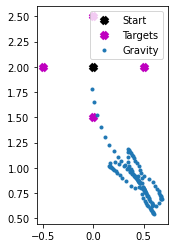

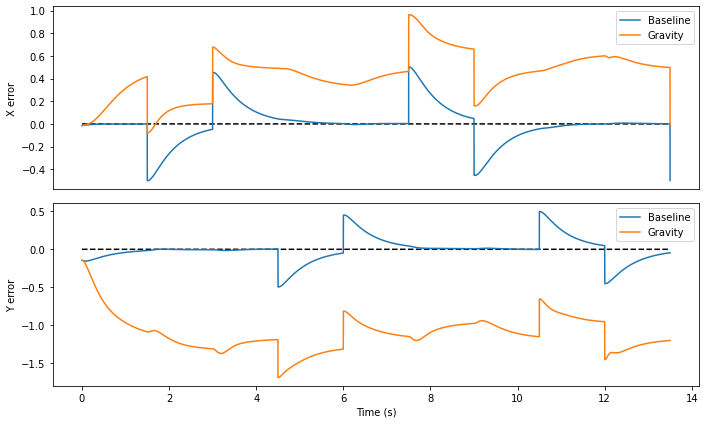

In [9]:
gravity_error = calculate_error(gravity_model, gravity_data)
plot_xy([gravity_t], [gravity_data[gravity_model.probe_hand]], ["Gravity"])
plot_data(
    [baseline_t, gravity_t], [baseline_error, gravity_error], ["Baseline", "Gravity"]
)

As expected, the error is much worse, especially along the Y axis
(take note of the scale of the axes),
because gravity is affecting the system
and the operational space controller is not accounting for it.

## Adding nonlinear adaptive control

Now we add in an ensemble of neurons
to perform context sensitive error integration,
as presented in DeWolf, Stewart, Slotine, and Eliasmith, 2015.
We want the context for adaptation to be the joint angles of the arm.
For optimal performance, the input to the ensemble should be
in the range -1 to 1, so we need to look at
the expected range of joint angles
and transform the input signal accordingly.

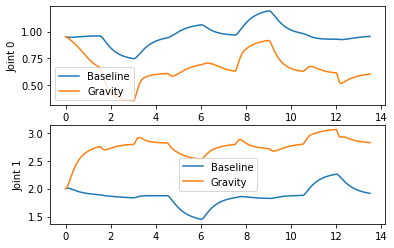

In [10]:
for ii in range(2):
    plt.subplot(2, 1, ii + 1)
    plt.plot(
        sim.trange(), baseline_data[baseline_model.probe_q][:, ii], label="Baseline"
    )
    plt.plot(sim.trange(), gravity_data[gravity_model.probe_q][:, ii], label="Gravity")
    plt.ylabel("Joint %i" % ii)
    plt.legend()

Looking at this data, we can estimate the mean of Joint 0
across the two runs to be around .75, with a range
of .75 to either side of the mean.
For Joint 1 it's a bit more difficult;
we're going to err to the Baseline values
with the hope the adaptive controller helps keep us in that range.
So we'll choose a mean of 2 and range of 1 to either side of the mean.

In [11]:
def add_adaptation(model, learning_rate=1e-5):
    with model:
        # create ensemble to adapt to unmodeled dynamics
        adapt = nengo.Ensemble(n_neurons=500, dimensions=2, radius=np.sqrt(2))

        means = np.array([0.75, 2.25])
        scaling = np.array([0.75, 1.25])
        scale_node = nengo.Node(
            output=lambda t, x: (x - means) / scaling, size_in=2, size_out=2
        )
        # to send target info to ensemble
        nengo.Connection(model.arm_node[:2], scale_node)
        nengo.Connection(scale_node, adapt)

        # create the learning connection from adapt to the arm simulation
        learn_conn = nengo.Connection(
            adapt,
            model.arm_node[2:4],
            function=lambda x: np.zeros(2),
            learning_rule_type=nengo.PES(learning_rate),
            synapse=0.05,
        )
        # connect up the osc signal as the training signal
        nengo.Connection(model.osc_node, learn_conn.learning_rule, transform=-1)
    return model


adapt_model = add_adaptation(add_gravity(build_baseline_model()))

In [12]:
arm_sim.reset()
with nengo.Simulator(adapt_model, progress_bar=False) as sim:
    sim.run(runtime)
adapt_t = sim.trange()
adapt_data = sim.data

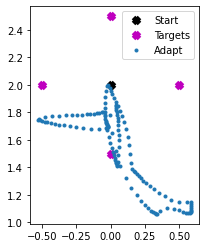

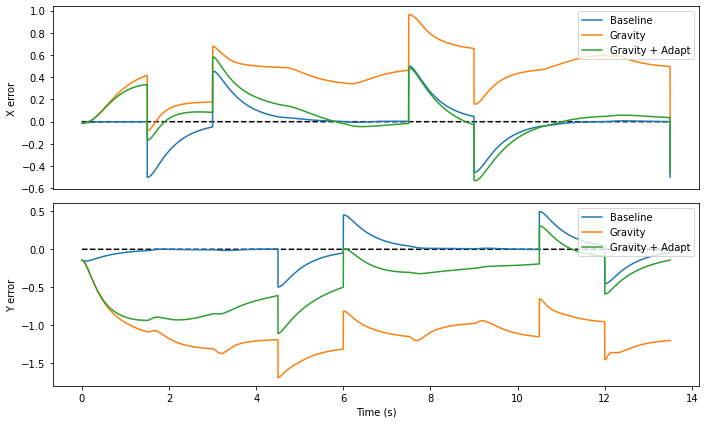

In [13]:
adapt_error = calculate_error(adapt_model, adapt_data)
plot_xy([adapt_t], [adapt_data[adapt_model.probe_hand]], ["Adapt"])
plot_data(
    [baseline_t, gravity_t, adapt_t],
    [baseline_error, gravity_error, adapt_error],
    ["Baseline", "Gravity", "Gravity + Adapt"],
)

And we can see that even in only one pass
through the target set the adaptive ensemble
has already significantly reduced the error.
To see further reductions,
change the run time of the simulation to be longer
so that the arm does multiple passes of the target set
(by changing `sim.run(runtime)` to `sim.run(runtime*2)`).

## Running the network with NengoLoihi

Loihi has limits on the magnitude of the
error signal, so we need to adjust the
`pes_error_scale` parameter to avoid too much overflow.

In [14]:
arm_sim.reset()

loihi_model = nengo_loihi.builder.Model()
loihi_model.pes_error_scale = 10

with nengo_loihi.Simulator(adapt_model, model=loihi_model) as sim:
    sim.run(runtime)
adapt_loihi_t = sim.trange()
adapt_loihi_data = sim.data

/home/tbekolay/Code/nengo-loihi/nengo_loihi/builder/discretize.py:180: UserWarning: Received PES error greater than chip max (1.27e+01). Consider changing `Model.pes_error_scale`.
  warnings.warn(
/home/tbekolay/Code/nengo-loihi/nengo_loihi/builder/discretize.py:190: UserWarning: Received PES error less than chip min (-1.27e+01). Consider changing `Model.pes_error_scale`.
  warnings.warn(


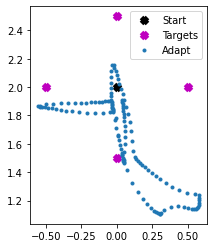

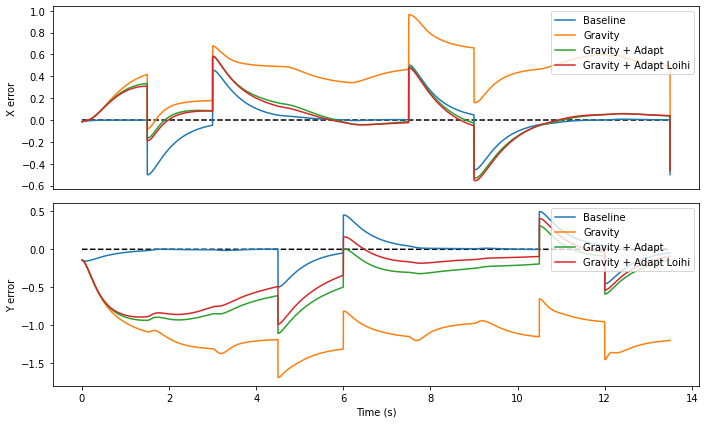

In [15]:
adapt_loihi_error = calculate_error(adapt_model, adapt_loihi_data)
plot_xy([adapt_loihi_t], [adapt_loihi_data[adapt_model.probe_hand]], ["Adapt"])
plot_data(
    [baseline_t, gravity_t, adapt_t, adapt_loihi_t],
    [baseline_error, gravity_error, adapt_error, adapt_loihi_error],
    ["Baseline", "Gravity", "Gravity + Adapt", "Gravity + Adapt Loihi"],
)